In [2]:
pip install optuna

In [3]:
pip install datasets

In [5]:
import numpy as np
import pandas as pd
import gzip
import json

from pprint import pprint
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


import re
import torch
import numpy as np
import pandas as pd
import json
import gzip

from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.utils.class_weight import compute_class_weight

from datasets import Dataset, DatasetDict

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import lightgbm as lgb
import optuna
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb
import optuna
from sklearn.metrics import accuracy_score, classification_report
import joblib

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
##### 1) Read train_classification.csv more carefully
train_classification_df = pd.read_csv("train-classification.csv")

# If "Unnamed: 0" is your user_id (and there's no user_id column yet), rename it
if "Unnamed: 0" in train_classification_df.columns and "user_id" not in train_classification_df.columns:
    train_classification_df.rename(columns={"Unnamed: 0": "user_id"}, inplace=True)

# Rename "label" to "category"
train_classification_df.rename(columns={"label": "category"}, inplace=True)

# 2) Read & unify the 3 annotation files in a loop
annotation_files = [
    "annotated_users_CS412-70f170887437.csv",
    "annotated_users_CS412-1210cecaf90d.csv",
    "annotated_users_CS412-2fa73b22df12.csv",
]

all_annotated = []
for ann_file in annotation_files:
    df_temp = pd.read_csv(ann_file)

    # Rename "Unnamed: 0" to "user_id" if needed
    if "Unnamed: 0" in df_temp.columns and "user_id" not in df_temp.columns:
        df_temp.rename(columns={"Unnamed: 0": "user_id"}, inplace=True)

    # Rename influencerCategory to category
    if "influencerCategory" in df_temp.columns:
        df_temp.rename(columns={"influencerCategory": "category"}, inplace=True)

    # Drop rows missing a category
    df_temp.dropna(subset=["category"], inplace=True)

    # Lowercase the category
    df_temp["category"] = df_temp["category"].str.lower()

    # Drop any unwanted columns that might exist
    for col in ["url", "influencerMention", "accountType"]:
        if col in df_temp.columns:
            df_temp.drop(columns=col, inplace=True)

    df_temp.reset_index(drop=True, inplace=True)
    all_annotated.append(df_temp)

annotated_users_df = pd.concat(all_annotated, ignore_index=True)

# 3) Combine with your train_classification_df
train_classification_df = pd.concat([train_classification_df, annotated_users_df],
                                    ignore_index=True)

# 4) Unify labels (make sure everything is lowercase, etc.)
train_classification_df["category"] = train_classification_df["category"].str.lower()

# 5) Remove duplicate user_ids if they appear multiple times
#    keep="last" keeps the final row of any duplicates
train_classification_df.drop_duplicates(subset="user_id", keep="last", inplace=True)
train_classification_df.reset_index(drop=True, inplace=True)

# 6) Create your mapping of user_id → category
username2_category = train_classification_df.set_index("user_id")["category"].to_dict()

In [7]:
import gzip
import json

train_data_path = "training-dataset.jsonl.gz"

username2posts_train = dict()
username2profile_train = dict()

username2posts_test = dict()
username2profile_test = dict()

try:
    with gzip.open(train_data_path, "rt") as fh:
        for line in fh:
            try:
                sample = json.loads(line)

                profile = sample["profile"]
                username = profile["username"]

                if username in username2_category:
                    # Train data info
                    username2posts_train[username] = sample["posts"]
                    username2profile_train[username] = profile
                else:
                    # Test data info
                    username2posts_test[username] = sample["posts"]
                    username2profile_test[username] = profile
            except json.JSONDecodeError as e:
                print(f"Skipping line due to JSON error: {e}")
except EOFError as e:
    print(f"Reached unexpected end of file: {e}")

In [8]:
# Profile Dataframe
train_profile_df = pd.DataFrame(username2profile_train).T.reset_index(drop=True)
test_profile_df = pd.DataFrame(username2profile_test).T.reset_index(drop=True)

In [ ]:
# profile: category_name biography entities business_category_name category_enum username full_name
# posts: captions

In [9]:
# 2) Preprocessing & Corpus-Building Functions

def preprocess_text(text: str):
    """
    Basic preprocessing for Turkish text:
    - Lower casing with .casefold()
    - Removing URLs
    - Removing special characters (optional: keep emojis if desired)
    - Removing digits
    - Stripping extra whitespace
    """
    # Lower-case (casefold is a more aggressive form of lower)
    text = text.casefold()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters except basic Turkish letters, numbers, hashtags, @
    text = re.sub(r'[^a-zçğıöşü\s#@]', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def build_corpus(username2posts, username2profile, include_all_features=True):
    """
    1. Loops over each username in username2posts
    2. Cleans each post caption using preprocess_text
    3. Optionally, appends user profile info (biography, category_name, etc.)
    4. Returns (corpus, usernames) for further processing
    """
    corpus = []
    usernames = []

    for username, posts in username2posts.items():
        usernames.append(username)

        # Collect and clean posts
        cleaned_captions = []
        for post in posts:
            post_caption = post.get("caption", "")
            if post_caption is None:
                continue
            post_caption = preprocess_text(post_caption)
            if post_caption:
                cleaned_captions.append(post_caption)

        # Optionally include profile features
        if include_all_features:
            profile = username2profile.get(username, {})
            feature_texts = []

            profile_fields = [
                "biography",
                "category_name",
                "entities",
                "business_category_name",
                "category_enum",
                "full_name"
            ]
            for field in profile_fields:
                value = profile.get(field, "")
                if value:
                    # Convert list/dict to string if needed
                    if isinstance(value, (dict, list)):
                        value = str(value)
                    value = preprocess_text(value)
                    if value:
                        feature_texts.append(value)

            # Combine all profile features and append
            if feature_texts:
                features_combined = " ".join(feature_texts)
                cleaned_captions.append(features_combined)

        # Combine everything into a single text for this user
        user_text = "\n".join(cleaned_captions)
        corpus.append(user_text)

    return corpus, usernames

# 3) Build the Train/Test Corpora

corpus_train, train_usernames = build_corpus(
    username2posts_train,    # Replace with your actual variable
    username2profile_train,  # Replace with your actual variable
    include_all_features=True
)
corpus_test, test_usernames = build_corpus(
    username2posts_test,     # Replace with your actual variable
    username2profile_test,   # Replace with your actual variable
    include_all_features=True
)

# Retrieve the labels for training (we assume test data is unlabeled or 'NA')
y_train = [username2_category.get(uname, "NA") for uname in train_usernames]  # Replace with your actual variable
assert y_train.count("NA") == 0, "Some training samples have 'NA' as category."

# 4) Train-Validation Split

x_train_texts, x_val_texts, y_train_labels, y_val_labels = train_test_split(
    corpus_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Training texts: {len(x_train_texts)}")
print(f"Validation texts: {len(x_val_texts)}")

# 5) Label Encoding

#label_encoder = LabelEncoder()
#y_train_encoded = label_encoder.fit_transform(y_train_labels)
#y_val_encoded = label_encoder.transform(y_val_labels)

# === Begin Class Merging ===

# Merge 'gaming' into 'tech' in training and validation labels
y_train_labels = ['tech' if label == 'gaming' else label for label in y_train_labels]
y_val_labels = ['tech' if label == 'gaming' else label for label in y_val_labels]

# Re-encode labels after merging
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_labels)
y_val_encoded = label_encoder.transform(y_val_labels)

print("Classes:", label_encoder.classes_)

# Recompute class weights after merging
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Updated Class weights after merging 'gaming' into 'tech':", class_weight_dict)

# Update training and validation DataFrames
train_df = pd.DataFrame({
    'text': x_train_texts,
    'label': y_train_encoded
})

val_df = pd.DataFrame({
    'text': x_val_texts,
    'label': y_val_encoded
})

# === End Class Merging ===

# 6) Create Hugging Face Datasets

# Create a pandas DataFrame for training
train_df = pd.DataFrame({
    'text': x_train_texts,
    'label': y_train_encoded
})

# Create a pandas DataFrame for validation
val_df = pd.DataFrame({
    'text': x_val_texts,
    'label': y_val_encoded
})

# Convert pandas DataFrame to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset
})

print(dataset)

# 7) Tokenization

model_name = "dbmdz/bert-base-turkish-uncased"  # or any Turkish BERT variant
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Rename 'label' to 'labels' as expected by the model
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

print(tokenized_datasets)

# 8) Compute Class Weights

# Recompute Class Weights with Updated Labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Recomputed Class weights after merging:", class_weight_dict)

# 9) Define Evaluation Metrics

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted', zero_division=0)
    acc = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

# 10) Define the Model

num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# 11) Define Training Arguments

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    report_to='none'
)

# 12) Define a Custom Trainer to Include Class Weights

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Convert class weights to float tensor and move to the model's device
        weight = torch.tensor(list(self.class_weights.values()), dtype=torch.float).to(model.device)
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# 13) Initialize the Custom Trainer

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=compute_metrics,
    class_weights=class_weight_dict
)


Training texts: 2263
Validation texts: 566
Classes: ['art' 'entertainment' 'fashion' 'food' 'health and lifestyle'
 'mom and children' 'sports' 'tech' 'travel']
Updated Class weights after merging 'gaming' into 'tech': {0: 1.6118233618233617, 1: 0.9488469601677149, 2: 1.0347508001828989, 3: 0.6001060726597719, 4: 0.5958399157451291, 5: 2.167624521072797, 6: 2.4651416122004357, 7: 0.8381481481481482, 8: 1.0476851851851852}
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2263
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 566
    })
})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/2263 [00:00<?, ? examples/s]

Map:   0%|          | 0/566 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2263
    })
    validation: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 566
    })
})
Recomputed Class weights after merging: {0: 1.6118233618233617, 1: 0.9488469601677149, 2: 1.0347508001828989, 3: 0.6001060726597719, 4: 0.5958399157451291, 5: 2.167624521072797, 6: 2.4651416122004357, 7: 0.8381481481481482, 8: 1.0476851851851852}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
# Assuming y_train_labels contains the original string labels
class_distribution = pd.Series(y_train_labels).value_counts()
print(class_distribution)


health and lifestyle    422
food                    419
tech                    300
entertainment           265
fashion                 243
travel                  240
art                     156
mom and children        116
sports                  102
Name: count, dtype: int64


In [11]:
# 14) Train the Model

trainer.train()


TrainOutput(global_step=426, training_loss=1.2565410797584784, metrics={'train_runtime': 261.7518, 'train_samples_per_second': 25.937, 'train_steps_per_second': 1.627, 'total_flos': 446593305413376.0, 'train_loss': 1.2565410797584784, 'epoch': 3.0})

In [12]:
# 15) Evaluate the Model

eval_results = trainer.evaluate()

print("\n--- Evaluation Results ---")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

# Detailed Classification Report

predictions, labels, _ = trainer.predict(tokenized_datasets['validation'])
preds = np.argmax(predictions, axis=1)

print("\n--- Detailed Classification Report ---")
print(classification_report(labels, preds, target_names=label_encoder.classes_, zero_division=0))



--- Evaluation Results ---
eval_loss: 1.2046
eval_accuracy: 0.6343
eval_precision: 0.6331
eval_recall: 0.6343
eval_f1: 0.6288
eval_runtime: 3.5825
eval_samples_per_second: 157.9910
eval_steps_per_second: 2.5120
epoch: 3.0000

--- Detailed Classification Report ---
                      precision    recall  f1-score   support

                 art       0.28      0.26      0.27        39
       entertainment       0.40      0.32      0.36        66
             fashion       0.66      0.70      0.68        61
                food       0.80      0.90      0.85       105
health and lifestyle       0.70      0.58      0.63       106
    mom and children       0.43      0.52      0.47        29
              sports       0.46      0.76      0.58        25
                tech       0.75      0.65      0.70        75
              travel       0.70      0.77      0.73        60

            accuracy                           0.63       566
           macro avg       0.58      0.61      0.5

In [13]:
# Save the model to a directory
trainer.save_model("fine_tuned_bert_model")


In [14]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-uncased')
model = BertModel.from_pretrained('dbmdz/bert-base-turkish-uncased')
model.eval()  # Set model to evaluation mode

# Function to extract [CLS] embeddings
def extract_cls_embeddings(texts, batch_size=32):
    embeddings = []
    dataloader = DataLoader(texts, batch_size=batch_size)

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting BERT Embeddings"):
            encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=128)
            input_ids = encoded_input['input_ids']
            attention_mask = encoded_input['attention_mask']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # [CLS] token embeddings
            embeddings.append(cls_embeddings.cpu().numpy())

    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

# Extract embeddings for training and validation sets
x_train_embeddings = extract_cls_embeddings(x_train_texts)
x_val_embeddings = extract_cls_embeddings(x_val_texts)


Extracting BERT Embeddings: 100%|██████████| 18/18 [02:35<00:00,  8.62s/it]


In [15]:
# Define Alignment Function

def align_embeddings_labels(usernames, embeddings, label_mapping):
    """
    Aligns embeddings with their corresponding labels based on usernames.

    Parameters:
    - usernames (list): List of usernames corresponding to embeddings.
    - embeddings (np.ndarray): Array of embeddings.
    - label_mapping (dict): Mapping from username to category.

    Returns:
    - filtered_embeddings (np.ndarray): Aligned embeddings.
    - filtered_usernames (list): Corresponding usernames.
    - filtered_labels (list): Corresponding labels.
    """
    usernames_array = np.array(usernames)
    valid_usernames = set(label_mapping.keys())

    # Create a boolean mask
    valid_mask = np.isin(usernames_array, list(valid_usernames))

    # Filter embeddings and usernames
    filtered_embeddings = embeddings[valid_mask]
    filtered_usernames = usernames_array[valid_mask].tolist()

    # Create labels
    filtered_labels = [label_mapping[u] for u in filtered_usernames]

    # Final verification
    assert filtered_embeddings.shape[0] == len(filtered_labels), "Mismatch between embeddings and labels!"

    return filtered_embeddings, filtered_usernames, filtered_labels

In [16]:

# Initialize the scaler
scaler = StandardScaler()

# Fit on training embeddings and transform both training and validation embeddings
x_train_scaled = scaler.fit_transform(x_train_embeddings)
x_val_scaled = scaler.transform(x_val_embeddings)

print("Training embeddings scaled.")

Training embeddings scaled.


In [17]:
# Initialize PCA - adjust n_components based on your dataset
pca = PCA(n_components=100, random_state=42)  # You can choose the number of components based on explained variance

# Fit PCA on training data and transform both training and validation data
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.transform(x_val_scaled)

print(f"PCA completed. Number of components: {pca.n_components_}")


PCA completed. Number of components: 100


In [18]:
# Prepare LightGBM datasets
train_data = lgb.Dataset(x_train_pca, label=y_train_encoded)
val_data = lgb.Dataset(x_val_pca, label=y_val_encoded, reference=train_data)


In [19]:
pip install dask[dataframe]

In [21]:
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Compute Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define Optuna Objective with PCA-Transformed Data and Class Weights
def objective_with_weights_pca(trial):
    param = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_train_encoded)),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10, log=True),
        'random_state': 42,
        'class_weight': class_weight_dict  # Apply class weights
    }

    # Use PCA-transformed training data
    model_lgbm = lgb.LGBMClassifier(**param)

    # Incorporate early stopping using callbacks with the PCA-transformed validation data.
    model_lgbm.fit(
        x_train_pca,
        y_train_encoded,
        eval_set=[(x_val_pca, y_val_encoded)],
        eval_metric='multi_logloss',
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # Use the best iteration for prediction
    val_preds = model_lgbm.predict(x_val_pca, num_iteration=model_lgbm.best_iteration_)
    val_accuracy = accuracy_score(y_val_encoded, val_preds)
    return val_accuracy

# Run Optuna Study with PCA-Transformed Data
study_weights = optuna.create_study(direction='maximize')
study_weights.optimize(objective_with_weights_pca, n_trials=50)

# Retrieve Best Parameters
best_params_weights = study_weights.best_params
best_params_weights['class_weight'] = class_weight_dict  # Add class weights

print("\nBest parameters with class weights:", best_params_weights)
print("Best cross-validation accuracy with class weights:", study_weights.best_value)

# Train Final Model with Best Parameters and Early Stopping using callbacks
final_model_weights = lgb.LGBMClassifier(**best_params_weights, random_state=42)
final_model_weights.fit(
    x_train_pca,
    y_train_encoded,
    eval_set=[(x_val_pca, y_val_encoded)],
    eval_metric='multi_logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)

# Evaluate on Validation Set using the best iteration
y_val_pred_weights = final_model_weights.predict(x_val_pca, num_iteration=final_model_weights.best_iteration_)
print("\n--- Validation Data Results with PCA, Class Weights, and Early Stopping ---")
print("Accuracy:", accuracy_score(y_val_encoded, y_val_pred_weights))
print("Classification Report:")
print(classification_report(y_val_encoded, y_val_pred_weights, target_names=label_encoder.classes_, zero_division=0))


[I 2025-01-12 18:09:49,815] A new study created in memory with name: no-name-871ee3ca-5996-4767-84b3-8cfb1410ced8
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Görüntülenen çıkış son 5000 satıra kısaltıldı.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:10:24,880] Trial 0 finished with value: 0.5477031802120141 and parameters: {'learning_rate': 0.01037510090146361, 'num_leaves': 78, 'max_depth': 39, 'n_estimators': 559, 'subsample': 0.8394988242055476, 'colsample_bytree': 0.6578443903752195, 'reg_lambda': 0.016565115351239272, 'reg_alpha': 4.724364714427543}. Best is trial 0 with value: 0.5477031802120141.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:10:45,254] Trial 1 finished with value: 0.5282685512367491 and parameters: {'learning_rate': 0.05244348490027604, 'num_leaves': 85, 'max_depth': 50, 'n_estimators': 865, 'subsample': 0.9123018414943562, 'colsample_bytree': 0.835469680280629, 'reg_lambda': 0.00019651608897880727, 'reg_alpha': 0.00024530149899710293}. Best is trial 0 with value: 0.5477031802120141.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:11:16,382] Trial 2 finished with value: 0.5441696113074205 and parameters: {'learning_rate': 0.021177308900169386, 'num_leaves': 85, 'max_depth': 43, 'n_estimators': 569, 'subsample': 0.6118719763974719, 'colsample_bytree': 0.71233020000733, 'reg_lambda': 0.05211146310766789, 'reg_alpha': 0.0012733516839945717}. Best is trial 0 with value: 0.5477031802120141.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:12:04,069] Trial 3 finished with value: 0.5547703180212014 and parameters: {'learning_rate': 0.016328165610142813, 'num_leaves': 149, 'max_depth': 35, 'n_estimators': 876, 'subsample': 0.7902342923420537, 'colsample_bytree': 0.8948814554993109, 'reg_lambda': 3.0484167410061085, 'reg_alpha': 0.016577519691396415}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Görüntülenen çıkış son 5000 satıra kısaltıldı.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:13:22,092] Trial 4 finished with value: 0.5335689045936396 and parameters: {'learning_rate': 0.003755962257197803, 'num_leaves': 86, 'max_depth': 9, 'n_estimators': 850, 'subsample': 0.880205830127277, 'colsample_bytree': 0.8843941847440081, 'reg_lambda': 0.07039533818486848, 'reg_alpha': 2.0058888678095204}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:13:31,664] Trial 5 finished with value: 0.5547703180212014 and parameters: {'learning_rate': 0.13723159628755738, 'num_leaves': 29, 'max_depth': 6, 'n_estimators': 190, 'subsample': 0.6374154599153873, 'colsample_bytree': 0.9630719007082417, 'reg_lambda': 6.886180928077163, 'reg_alpha': 0.003486439643437743}. Best is trial 3 with value: 0.5547703180212014.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:14:14,495] Trial 6 finished with value: 0.549469964664311 and parameters: {'learning_rate': 0.013247823367321998, 'num_leaves': 83, 'max_depth': 12, 'n_estimators': 279, 'subsample': 0.8605487843846926, 'colsample_bytree': 0.7811985679683878, 'reg_lambda': 0.03219350976993504, 'reg_alpha': 0.030292284050548325}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:15:19,922] Trial 7 finished with value: 0.5335689045936396 and parameters: {'learning_rate': 0.009174845707290942, 'num_leaves': 73, 'max_depth': 12, 'n_estimators': 564, 'subsample': 0.7425277910717101, 'colsample_bytree': 0.9741562246041793, 'reg_lambda': 0.000590340096574064, 'reg_alpha': 0.33239712750407213}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:16:58,822] Trial 8 finished with value: 0.5265017667844523 and parameters: {'learning_rate': 0.007034043571424747, 'num_leaves': 118, 'max_depth': 49, 'n_estimators': 992, 'subsample': 0.7312510818455096, 'colsample_bytree': 0.9778980573366031, 'reg_lambda': 0.007563770468650495, 'reg_alpha': 0.063755513479742}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:17:07,806] Trial 9 finished with value: 0.5424028268551236 and parameters: {'learning_rate': 0.009176710724804422, 'num_leaves': 21, 'max_depth': 13, 'n_estimators': 173, 'subsample': 0.6369961394567536, 'colsample_bytree': 0.6811504714980972, 'reg_lambda': 0.0001023481532824269, 'reg_alpha': 3.044913152757837}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Görüntülenen çıkış son 5000 satıra kısaltıldı.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:18:09,003] Trial 10 finished with value: 0.5159010600706714 and parameters: {'learning_rate': 0.0013970033774490598, 'num_leaves': 150, 'max_depth': 27, 'n_estimators': 760, 'subsample': 0.9897390532771546, 'colsample_bytree': 0.8666476655050533, 'reg_lambda': 9.577011893733529, 'reg_alpha': 0.010482344730363944}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:18:15,985] Trial 11 finished with value: 0.5459363957597173 and parameters: {'learning_rate': 0.2456166732238296, 'num_leaves': 24, 'max_depth': 27, 'n_estimators': 364, 'subsample': 0.7065604191890122, 'colsample_bytree': 0.9206370328700673, 'reg_lambda': 8.77174888024433, 'reg_alpha': 0.0033460913378172185}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:18:27,118] Trial 12 finished with value: 0.5388692579505301 and parameters: {'learning_rate': 0.1088716291816413, 'num_leaves': 51, 'max_depth': 21, 'n_estimators': 364, 'subsample': 0.7885896269217777, 'colsample_bytree': 0.9284946928840255, 'reg_lambda': 0.839742558060157, 'reg_alpha': 0.00013760248964946536}. Best is trial 3 with value: 0.5547703180212014.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:18:48,275] Trial 13 finished with value: 0.5441696113074205 and parameters: {'learning_rate': 0.040846618059356715, 'num_leaves': 149, 'max_depth': 36, 'n_estimators': 707, 'subsample': 0.6714270240901421, 'colsample_bytree': 0.7890188720319465, 'reg_lambda': 0.9577443172134361, 'reg_alpha': 0.001280099444385688}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:18:53,879] Trial 14 finished with value: 0.5353356890459364 and parameters: {'learning_rate': 0.25758433436554623, 'num_leaves': 117, 'max_depth': 34, 'n_estimators': 105, 'subsample': 0.7864320364719194, 'colsample_bytree': 0.9308149832133258, 'reg_lambda': 0.9471512615421868, 'reg_alpha': 0.11870703598745443}. Best is trial 3 with value: 0.5547703180212014.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:19:16,166] Trial 15 finished with value: 0.5371024734982333 and parameters: {'learning_rate': 0.04031554890673331, 'num_leaves': 41, 'max_depth': 19, 'n_estimators': 435, 'subsample': 0.9468086942800075, 'colsample_bytree': 0.9937970976315281, 'reg_lambda': 2.3525483165729715, 'reg_alpha': 0.004466130090410422}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:19:22,444] Trial 16 finished with value: 0.5265017667844523 and parameters: {'learning_rate': 0.10623622320348883, 'num_leaves': 117, 'max_depth': 6, 'n_estimators': 986, 'subsample': 0.678384646452426, 'colsample_bytree': 0.6011268133353114, 'reg_lambda': 0.21321237187970113, 'reg_alpha': 0.016794959570801}. Best is trial 3 with value: 0.5547703180212014.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:19:52,113] Trial 17 finished with value: 0.5141342756183745 and parameters: {'learning_rate': 0.0032781291266870995, 'num_leaves': 61, 'max_depth': 31, 'n_estimators': 230, 'subsample': 0.8256502615619725, 'colsample_bytree': 0.8353253198827519, 'reg_lambda': 0.25140628032274054, 'reg_alpha': 0.30926432093260564}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:20:06,877] Trial 18 finished with value: 0.5247349823321554 and parameters: {'learning_rate': 0.10936393139375304, 'num_leaves': 102, 'max_depth': 22, 'n_estimators': 706, 'subsample': 0.7507810724274926, 'colsample_bytree': 0.8971027946761453, 'reg_lambda': 0.0034174650008834077, 'reg_alpha': 0.0005786163250882022}. Best is trial 3 with value: 0.5547703180212014.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:20:35,968] Trial 19 finished with value: 0.5547703180212014 and parameters: {'learning_rate': 0.024457816977719333, 'num_leaves': 137, 'max_depth': 43, 'n_estimators': 419, 'subsample': 0.6000424337973411, 'colsample_bytree': 0.7468822010939433, 'reg_lambda': 2.270789593641643, 'reg_alpha': 0.007130055154086269}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:20:49,831] Trial 20 finished with value: 0.5441696113074205 and parameters: {'learning_rate': 0.06686102019065975, 'num_leaves': 39, 'max_depth': 17, 'n_estimators': 649, 'subsample': 0.6518120709255487, 'colsample_bytree': 0.8398189005891564, 'reg_lambda': 3.4426574808504338, 'reg_alpha': 0.0022438781747286082}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:21:27,098] Trial 21 finished with value: 0.5459363957597173 and parameters: {'learning_rate': 0.018655458226145616, 'num_leaves': 135, 'max_depth': 44, 'n_estimators': 463, 'subsample': 0.6017465117199147, 'colsample_bytree': 0.74373340176518, 'reg_lambda': 3.007252570895543, 'reg_alpha': 0.00937831842931184}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:21:54,650] Trial 22 finished with value: 0.5247349823321554 and parameters: {'learning_rate': 0.030259862990092173, 'num_leaves': 130, 'max_depth': 41, 'n_estimators': 459, 'subsample': 0.7075240857897854, 'colsample_bytree': 0.9489643753643956, 'reg_lambda': 0.2038454558489877, 'reg_alpha': 0.0643153904498648}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:22:24,610] Trial 23 finished with value: 0.5406360424028268 and parameters: {'learning_rate': 0.024205825180020586, 'num_leaves': 134, 'max_depth': 32, 'n_estimators': 360, 'subsample': 0.6376477990411565, 'colsample_bytree': 0.752921841508625, 'reg_lambda': 3.8644197467920236, 'reg_alpha': 0.007540190271627942}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:23:02,811] Trial 24 finished with value: 0.5141342756183745 and parameters: {'learning_rate': 0.005287742471532346, 'num_leaves': 101, 'max_depth': 46, 'n_estimators': 261, 'subsample': 0.6883121661904471, 'colsample_bytree': 0.868921689566321, 'reg_lambda': 0.6237542303389386, 'reg_alpha': 0.025830328141410754}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:23:11,698] Trial 25 finished with value: 0.5459363957597173 and parameters: {'learning_rate': 0.16239342367736323, 'num_leaves': 140, 'max_depth': 38, 'n_estimators': 120, 'subsample': 0.7719354579165991, 'colsample_bytree': 0.8085746948145837, 'reg_lambda': 1.606590961347144, 'reg_alpha': 0.0008580575006642949}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:23:39,677] Trial 26 finished with value: 0.49469964664310956 and parameters: {'learning_rate': 0.002018692111340855, 'num_leaves': 98, 'max_depth': 30, 'n_estimators': 307, 'subsample': 0.6015212484105281, 'colsample_bytree': 0.9606897666650527, 'reg_lambda': 8.679218881914018, 'reg_alpha': 0.00033133672770739657}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:23:53,685] Trial 27 finished with value: 0.5547703180212014 and parameters: {'learning_rate': 0.07364846222086564, 'num_leaves': 122, 'max_depth': 25, 'n_estimators': 188, 'subsample': 0.6374146510847475, 'colsample_bytree': 0.7395091172403745, 'reg_lambda': 0.3061581086570482, 'reg_alpha': 0.003468948984931108}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:24:41,126] Trial 28 finished with value: 0.5335689045936396 and parameters: {'learning_rate': 0.014730554893147754, 'num_leaves': 109, 'max_depth': 35, 'n_estimators': 911, 'subsample': 0.6566984797899588, 'colsample_bytree': 0.9040273177905419, 'reg_lambda': 0.11830686208501988, 'reg_alpha': 0.1631302830537439}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:25:00,714] Trial 29 finished with value: 0.5512367491166078 and parameters: {'learning_rate': 0.031183175510067256, 'num_leaves': 65, 'max_depth': 39, 'n_estimators': 634, 'subsample': 0.8302930557395987, 'colsample_bytree': 0.6842650725160001, 'reg_lambda': 0.47991728378349646, 'reg_alpha': 0.9340796445738253}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:25:06,368] Trial 30 finished with value: 0.5459363957597173 and parameters: {'learning_rate': 0.18391173822085724, 'num_leaves': 143, 'max_depth': 5, 'n_estimators': 517, 'subsample': 0.7122297852407531, 'colsample_bytree': 0.6184213223854577, 'reg_lambda': 4.203701080649564, 'reg_alpha': 0.04921744532582457}. Best is trial 3 with value: 0.5547703180212014.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:25:21,601] Trial 31 finished with value: 0.5512367491166078 and parameters: {'learning_rate': 0.06928829114040135, 'num_leaves': 125, 'max_depth': 24, 'n_estimators': 187, 'subsample': 0.628312072857313, 'colsample_bytree': 0.735163946541354, 'reg_lambda': 1.8202825300543224, 'reg_alpha': 0.004517933499523769}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:25:37,283] Trial 32 finished with value: 0.5406360424028268 and parameters: {'learning_rate': 0.06245538998984154, 'num_leaves': 126, 'max_depth': 16, 'n_estimators': 186, 'subsample': 0.6596337418923776, 'colsample_bytree': 0.7102102698087779, 'reg_lambda': 0.449447318276054, 'reg_alpha': 0.002436591002396131}. Best is trial 3 with value: 0.5547703180212014.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:25:48,878] Trial 33 finished with value: 0.5565371024734982 and parameters: {'learning_rate': 0.09002151664177138, 'num_leaves': 140, 'max_depth': 46, 'n_estimators': 411, 'subsample': 0.6262646852813519, 'colsample_bytree': 0.7702452851507174, 'reg_lambda': 4.737091344864392, 'reg_alpha': 0.014789571454851349}. Best is trial 33 with value: 0.5565371024734982.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:25:58,248] Trial 34 finished with value: 0.5565371024734982 and parameters: {'learning_rate': 0.1614659242328266, 'num_leaves': 139, 'max_depth': 48, 'n_estimators': 418, 'subsample': 0.6275833367574127, 'colsample_bytree': 0.766953293468805, 'reg_lambda': 5.5808822384481696, 'reg_alpha': 0.020444675963612366}. Best is trial 33 with value: 0.5565371024734982.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:26:00,222] Trial 35 finished with value: 0.5441696113074205 and parameters: {'learning_rate': 0.1789077491331327, 'num_leaves': 144, 'max_depth': 50, 'n_estimators': 531, 'subsample': 0.8760644127854175, 'colsample_bytree': 0.8154861328273818, 'reg_lambda': 5.45878950431118, 'reg_alpha': 9.84114912082387}. Best is trial 33 with value: 0.5565371024734982.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:26:10,911] Trial 36 finished with value: 0.5600706713780919 and parameters: {'learning_rate': 0.14123745408321192, 'num_leaves': 92, 'max_depth': 47, 'n_estimators': 805, 'subsample': 0.9278145163395496, 'colsample_bytree': 0.8378367020806327, 'reg_lambda': 5.4372086535315, 'reg_alpha': 0.017207681822911627}. Best is trial 36 with value: 0.5600706713780919.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:26:32,125] Trial 37 finished with value: 0.5353356890459364 and parameters: {'learning_rate': 0.04405561163556794, 'num_leaves': 90, 'max_depth': 48, 'n_estimators': 821, 'subsample': 0.9114285908458695, 'colsample_bytree': 0.8385726258222373, 'reg_lambda': 1.4401806080603372, 'reg_alpha': 0.015443370312312807}. Best is trial 36 with value: 0.5600706713780919.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:26:45,707] Trial 38 finished with value: 0.5265017667844523 and parameters: {'learning_rate': 0.09016451414902688, 'num_leaves': 110, 'max_depth': 46, 'n_estimators': 920, 'subsample': 0.8119659689717958, 'colsample_bytree': 0.7720193204272515, 'reg_lambda': 0.0012767232154522064, 'reg_alpha': 0.02109441195576571}. Best is trial 36 with value: 0.5600706713780919.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:26:50,531] Trial 39 finished with value: 0.5141342756183745 and parameters: {'learning_rate': 0.2669694873137507, 'num_leaves': 75, 'max_depth': 41, 'n_estimators': 827, 'subsample': 0.9189873104631066, 'colsample_bytree': 0.8604517147469404, 'reg_lambda': 0.013175552456066225, 'reg_alpha': 0.04305020576615555}. Best is trial 36 with value: 0.5600706713780919.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:26:57,145] Trial 40 finished with value: 0.5530035335689046 and parameters: {'learning_rate': 0.14929759099837128, 'num_leaves': 145, 'max_depth': 46, 'n_estimators': 785, 'subsample': 0.9907036696103689, 'colsample_bytree': 0.7758759250320802, 'reg_lambda': 0.0676482602362, 'reg_alpha': 0.564273691282367}. Best is trial 36 with value: 0.5600706713780919.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:27:04,297] Trial 41 finished with value: 0.5459363957597173 and parameters: {'learning_rate': 0.15791455729836873, 'num_leaves': 29, 'max_depth': 42, 'n_estimators': 898, 'subsample': 0.8514911373177199, 'colsample_bytree': 0.8156222876045431, 'reg_lambda': 6.13174050562549, 'reg_alpha': 0.09023759923758276}. Best is trial 36 with value: 0.5600706713780919.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:27:18,441] Trial 42 finished with value: 0.5671378091872792 and parameters: {'learning_rate': 0.12661262364556566, 'num_leaves': 68, 'max_depth': 48, 'n_estimators': 602, 'subsample': 0.6222123030611663, 'colsample_bytree': 0.9992853646843161, 'reg_lambda': 9.605138345255202, 'reg_alpha': 0.01382287461619999}. Best is trial 42 with value: 0.5671378091872792.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:27:26,449] Trial 43 finished with value: 0.549469964664311 and parameters: {'learning_rate': 0.22389591405468132, 'num_leaves': 56, 'max_depth': 48, 'n_estimators': 613, 'subsample': 0.625919630513693, 'colsample_bytree': 0.79988555989516, 'reg_lambda': 5.232752197997828, 'reg_alpha': 0.036686821397642205}. Best is trial 42 with value: 0.5671378091872792.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:27:36,609] Trial 44 finished with value: 0.5618374558303887 and parameters: {'learning_rate': 0.11744639109987996, 'num_leaves': 80, 'max_depth': 45, 'n_estimators': 488, 'subsample': 0.9416337147770979, 'colsample_bytree': 0.7142776011596453, 'reg_lambda': 8.34039979818313, 'reg_alpha': 0.012209888797640874}. Best is trial 42 with value: 0.5671378091872792.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:27:51,541] Trial 45 finished with value: 0.5547703180212014 and parameters: {'learning_rate': 0.08895358795611848, 'num_leaves': 80, 'max_depth': 45, 'n_estimators': 499, 'subsample': 0.9579868050345488, 'colsample_bytree': 0.708860338409671, 'reg_lambda': 9.007540132199251, 'reg_alpha': 0.014416465148519976}. Best is trial 42 with value: 0.5671378091872792.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:28:02,131] Trial 46 finished with value: 0.5530035335689046 and parameters: {'learning_rate': 0.12460092961651303, 'num_leaves': 71, 'max_depth': 50, 'n_estimators': 588, 'subsample': 0.9034059015279753, 'colsample_bytree': 0.6627022492657937, 'reg_lambda': 1.2180694339050877, 'reg_alpha': 0.006145208304768073}. Best is trial 42 with value: 0.5671378091872792.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:28:08,744] Trial 47 finished with value: 0.5441696113074205 and parameters: {'learning_rate': 0.2203520339389222, 'num_leaves': 92, 'max_depth': 48, 'n_estimators': 412, 'subsample': 0.9380133099636689, 'colsample_bytree': 0.7652412384026729, 'reg_lambda': 2.7611066870882492, 'reg_alpha': 0.1762484535017883}. Best is trial 42 with value: 0.5671378091872792.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:28:16,189] Trial 48 finished with value: 0.5459363957597173 and parameters: {'learning_rate': 0.29902900230801044, 'num_leaves': 67, 'max_depth': 44, 'n_estimators': 343, 'subsample': 0.9730953741288313, 'colsample_bytree': 0.6945683037979072, 'reg_lambda': 5.86641931714632, 'reg_alpha': 0.011254679720055151}. Best is trial 42 with value: 0.5671378091872792.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-12 18:28:34,693] Trial 49 finished with value: 0.558303886925795 and parameters: {'learning_rate': 0.05120267408332144, 'num_leaves': 85, 'max_depth': 38, 'n_estimators': 679, 'subsample': 0.8984623015457094, 'colsample_bytree': 0.730184719218777, 'reg_lambda': 3.974265751071883, 'reg_alpha': 0.027596156656974884}. Best is trial 42 with value: 0.5671378091872792.
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Best parameters with class weights: {'learning_rate': 0.12661262364556566, 'num_leaves': 68, 'max_depth': 48, 'n_estimators': 602, 'subsample': 0.6222123030611663, 'colsample_bytree': 0.9992853646843161, 'reg_lambda': 9.605138345255202, 'reg_alpha': 0.01382287461619999, 'class_weight': {0: 1.6118233618233617, 1: 0.9488469601677149, 2: 1.0347508001828989, 3: 0.6001060726597719, 4: 0.5958399157451291, 5: 2.167624521072797, 6: 2.4651416122004357, 7: 0.8381481481481482, 8: 1.0476851851851852}}
Best cross-validation accuracy with class weights: 0.5671378091872792
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 2263, number of used features: 100
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training fro

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [22]:
from joblib import dump

# Save BERT model and tokenizer
model.save_pretrained("bert_model")
tokenizer.save_pretrained("bert_model")
print("BERT model and tokenizer saved successfully.")

# Save LightGBM model
final_model_weights.booster_.save_model("lightgbm_model.txt")
print("LightGBM model saved successfully.")

# Save scaler, PCA, and label encoder
dump(scaler, "scaler.joblib")
dump(pca, "pca.joblib")
dump(label_encoder, "label_encoder.joblib")
print("Preprocessing objects saved successfully.")



BERT model and tokenizer saved successfully.
LightGBM model saved successfully.
Preprocessing objects saved successfully.


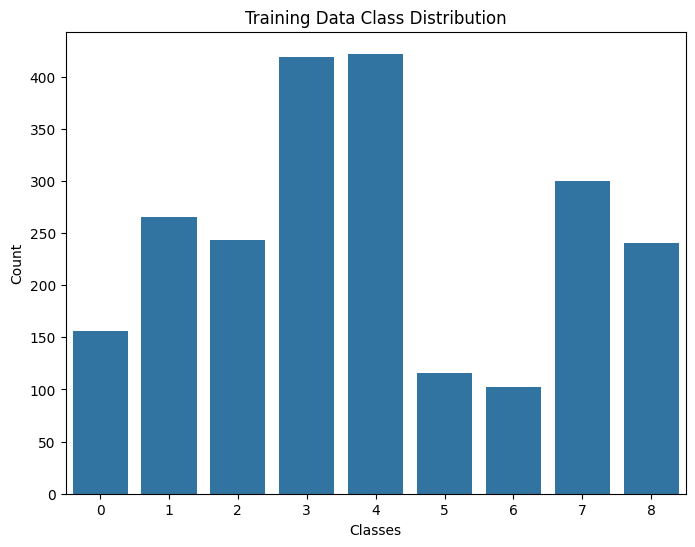

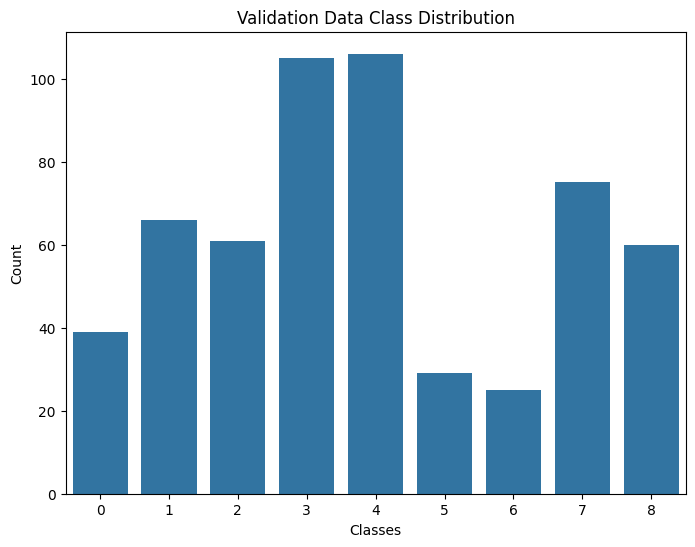

In [23]:
# Training data class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_encoded)
plt.title('Training Data Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

# Validation data class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y_val_encoded)
plt.title('Validation Data Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()


In [24]:
# Step 1: Load usernames from test-classification-round3.dat
with open("test-classification-round3.dat", "r", encoding="utf-8") as file:
    usernames = file.read().strip().split("\n")

# Step 2: Simulate username-to-post and username-to-profile mappings
# Modify to include structured data for posts and profiles
username2posts_test = {username: [{"caption": f"Sample post caption for {username}"}] for username in usernames}
username2profile_test = {username: {"bio": f"Sample bio for {username}"} for username in usernames}

# Step 3: Build corpus for test set
corpus_test, test_usernames = build_corpus(
    username2posts_test,
    username2profile_test,
    include_all_features=True
)
x_test_texts = corpus_test

# Step 4: Extract BERT embeddings
x_test_embeddings = extract_cls_embeddings(x_test_texts)

# Step 5: Scale the embeddings (Use the scaler fitted on training data)
x_test_scaled = scaler.transform(x_test_embeddings)

# Step 6: Transform using PCA (Use the PCA fitted on training data)
x_test_pca = pca.transform(x_test_scaled)
print(f"Test data transformed using PCA. Shape: {x_test_pca.shape}")

# Step 7: Predict using the final trained LightGBM model
test_preds = final_model_weights.predict_proba(x_test_pca)  # Use predict_proba for probabilities
test_pred_classes = np.argmax(test_preds, axis=1)  # Get class predictions
decoded_preds = label_encoder.inverse_transform(test_pred_classes)  # Decode to original labels

# Define the format_category function
def format_category(category):
    """
    Formats the category by capitalizing each word except "and".
    """
    words = category.split()
    formatted_words = [word.capitalize() if word.lower() != "and" else word for word in words]
    return " ".join(formatted_words)

# Step 8: Format and save predictions
output = {uname: format_category(decoded_preds[i]) for i, uname in enumerate(test_usernames)}
with open("task1_round3.json", "w", encoding='utf-8') as of:
    json.dump(output, of, indent=4, ensure_ascii=False)

print("Predictions saved to output.json successfully.")


Extracting BERT Embeddings: 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]

Test data transformed using PCA. Shape: (1000, 100)
Predictions saved to output.json successfully.



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [25]:
#REGRESSION, TASK TWO

import numpy as np
import pandas as pd
import optuna
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import json
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [35]:
import pandas as pd
import json
import gzip

# Step 1: Define the file path
file_path = 'training-dataset.jsonl.gz'

# Step 2: Read and extract posts with profile data
all_posts = []

with gzip.open(file_path, 'rt', encoding='utf-8') as f:
    for line_number, line in enumerate(f, 1):
        try:
            data = json.loads(line)

            # Extract profile information
            profile = data.get('profile', {})
            username = profile.get('username')
            follower_count = profile.get('follower_count')
            is_verified = profile.get('is_verified')

            # Extract posts
            posts = data.get('posts', [])
            for post in posts:
                # Associate profile data with each post
                post['username'] = username
                post['follower_count'] = follower_count
                post['is_verified'] = is_verified

                # Append the enriched post to the list
                all_posts.append(post)

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON on line {line_number}: {e}")

# Step 3: Convert to DataFrame and set 'id' as index
df = pd.DataFrame(all_posts)

if 'id' in df.columns:
    df = df.set_index('id')
else:
    raise KeyError("The 'id' column is missing from the posts data.")

# Step 3.2: Replace 'null' strings in 'caption' with empty strings**
if 'caption' in df.columns:
    df['caption'] = df['caption'].fillna('')
else:
    print("Warning: Column 'caption' not found in DataFrame.")

# Step 4: Clean and Convert Numeric Columns
numeric_columns = ['comments_count', 'like_count', 'follower_count']
for col in numeric_columns:
    if col in df.columns:
        # Replace 'null' strings with '0'
        df[col] = df[col].replace('null', '0')
        # Convert to numeric, coercing errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Fill NaN values with 0
        df[col] = df[col].fillna(0)
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

# Step 5: Map 'media_type' to numeric values
if 'media_type' in df.columns:
    df['media_type'] = df['media_type'].map({'VIDEO': 2, 'IMAGE': 1, 'CAROUSEL_ALBUM': 0})
    # Convert to numeric, coercing errors to NaN
    df['media_type'] = pd.to_numeric(df['media_type'], errors='coerce')
    # Fill NaN values with a default value (e.g., -1) for unmapped types
    df['media_type'] = df['media_type'].fillna(-1)
else:
    print("Warning: Column 'media_type' not found in DataFrame.")

# Step 6: Convert 'is_verified' to numeric
if 'is_verified' in df.columns:
    df['is_verified'] = df['is_verified'].map({True: 1, False: 0})
    # Convert to numeric, coercing errors to NaN
    df['is_verified'] = pd.to_numeric(df['is_verified'], errors='coerce')
    # Fill NaN values with 0 (assuming unverified if missing)
    df['is_verified'] = df['is_verified'].fillna(0)
else:
    print("Warning: Column 'is_verified' not found in DataFrame.")

# Step 7: Handle 'username' Column
# Example: Encode 'username' as categorical codes
if 'username' in df.columns:
    df['username_encoded'] = df['username'].astype('category').cat.codes
else:
    print("Warning: Column 'username' not found in DataFrame.")

# Alternatively, uncomment the following lines for one-hot encoding
# if 'username' in df.columns:
#     df = pd.get_dummies(df, columns=['username'], prefix='user')
# else:
#     print("Warning: Column 'username' not found in DataFrame.")

# Step 8: Drop 'media_url' column
if 'media_url' in df.columns:
    df = df.drop(columns=['media_url'])
else:
    print("Warning: Column 'media_url' not found in DataFrame.")

# Step 9: Convert 'timestamp' to datetime
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
else:
    print("Warning: Column 'timestamp' not found in DataFrame.")

# Step 11: Feature Engineering (Optional)
# Example: Extract hour and day of week from timestamp
if 'timestamp' in df.columns:
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['month'] = df['timestamp'].dt.month

# Example: Create 'likes_per_comment' feature
df['likes_per_comment'] = df['like_count'] / (df['comments_count'] + 1)

# Step 12: Data Validation
# Check for duplicates
if df.index.is_unique:
    print("All IDs are unique.")
else:
    print(f"Found {df.index.duplicated().sum()} duplicate IDs.")
    df = df[~df.index.duplicated(keep='first')]

All IDs are unique.


In [ ]:
import numpy as np
import pandas as pd
import optuna
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import json
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

#############################################
# Assume "df" is your preprocessed training DataFrame.
# It has 187302 entries and 13 columns. For regression, we use a subset of features:
#############################################
features = ['comments_count', 'media_type', 'follower_count', 'is_verified',
            'username_encoded', 'hour', 'day_of_week', 'month', 'likes_per_comment']
target = 'like_count'

# Ensure required columns exist in df.
missing_train = set(features + [target]) - set(df.columns)
if missing_train:
    raise KeyError(f"The following required columns are missing from the training data: {missing_train}")

# Select features and target.
X = df[features].copy()
y = df[target].copy()

#############################################
# 1) Log10 Transformation on Target (to handle heavy tail)
#############################################
y_log = np.log10(y + 1)

#############################################
# 2) Train-Test Split
#############################################
X_train, X_valid, y_train_log, y_valid_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
print("\nData Split:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Validation set: {X_valid.shape[0]} samples")

#############################################
# 3) OPTUNA HYPERPARAMETER TUNING
#############################################
def objective(trial):
    """
    Objective function that tests between RandomForestRegressor and GradientBoostingRegressor.
    Hyperparameters are tuned using cross-validation on the log-transformed target.
    In case of any error during CV (for example, misconfiguration), it returns np.inf.
    """
    model_type = trial.suggest_categorical("model_type", ["RandomForest", "GradientBoosting"])

    if model_type == "RandomForest":
        n_estimators = trial.suggest_int("rf_n_estimators", 50, 300)
        max_depth = trial.suggest_int("rf_max_depth", 5, 30)
        min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 10)
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1
        )
    else:  # GradientBoosting
        n_estimators = trial.suggest_int("gb_n_estimators", 50, 300)
        learning_rate = trial.suggest_float("gb_learning_rate", 0.01, 0.2, log=True)
        max_depth = trial.suggest_int("gb_max_depth", 3, 15)
        subsample = trial.suggest_float("gb_subsample", 0.6, 1.0)
        model = GradientBoostingRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            random_state=42
        )

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", model)
    ])

    # Use as many folds as possible (up to 5)
    cv_folds = min(5, len(X_train))
    try:
        cv_scores = cross_val_score(
            pipeline,
            X_train,
            y_train_log,
            cv=cv_folds,
            scoring="neg_mean_squared_error",
            n_jobs=-1
        )
        mean_mse = -np.mean(cv_scores)
    except Exception:
        return np.inf
    return mean_mse

study = optuna.create_study(direction="minimize")
print("\nStarting Optuna hyperparameter optimization...")
study.optimize(objective, n_trials=50)

print("\nBest trial:")
best_trial = study.best_trial
print("  MSE (log-scale):", best_trial.value)
print("  Best hyperparameters:", best_trial.params)

#############################################
# 4) TRAINING THE FINAL MODEL
#############################################
best_model_type = best_trial.params["model_type"]
if best_model_type == "RandomForest":
    best_model = RandomForestRegressor(
        n_estimators=best_trial.params["rf_n_estimators"],
        max_depth=best_trial.params["rf_max_depth"],
        min_samples_split=best_trial.params["rf_min_samples_split"],
        random_state=42,
        n_jobs=-1
    )
else:
    best_model = GradientBoostingRegressor(
        n_estimators=best_trial.params["gb_n_estimators"],
        learning_rate=best_trial.params["gb_learning_rate"],
        max_depth=best_trial.params["gb_max_depth"],
        subsample=best_trial.params["gb_subsample"],
        random_state=42
    )

final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", best_model)
])

print("\nTraining the final model with the best hyperparameters...")
final_pipeline.fit(X_train, y_train_log)
print("Final model training completed.")

# Evaluate on the validation set.
y_valid_pred_log = final_pipeline.predict(X_valid)
mse_valid_log = mean_squared_error(y_valid_log, y_valid_pred_log)
print("\nValidation MSE on log10(like_count):", mse_valid_log)

#############################################
# 5) MAKE PREDICTIONS ON TEST DATA AND OUTPUT JSON
#############################################
# Test data is assumed to be in a JSON Lines file (each line one JSON object) that contains an 'id'
# and the same features as used during training.
# For example, a test line might be:
# {"id": "17918493004647925", "comments_count": 15, "media_type": 1, "follower_count": 12000,
#  "is_verified": 0, "username_encoded": 123, "hour": 13, "day_of_week": 2, "month": 9, "likes_per_comment": 5}
try:
    df_test = pd.read_json("test-regression-round3.jsonl", lines=True)
    print("\nTest Data Loaded Successfully.")
    print("Test Data shape:", df_test.shape)
    print(df_test.head())
except ValueError as ve:
    raise ValueError("Error reading 'test-regression-round3.jsonl'. Please verify the JSON structure.") from ve
except FileNotFoundError:
    raise FileNotFoundError("The file 'test-regression-round3.jsonl' was not found. Please check the file path.")

# Check that the test data contains an "id" column.
if "id" not in df_test.columns:
    print("Available columns in test data:", df_test.columns.tolist())
    raise ValueError("The test data must contain an 'id' column as the identifier.")

test_ids = df_test["id"].astype(str)
X_test = df_test.drop(columns=["id"], errors="ignore")

# For any feature that is missing in test data, add it with the training median.
for col in features:
    if col not in X_test.columns:
        print(f"Test data is missing feature '{col}'. Filling with training median value.")
        X_test[col] = X_train[col].median()

# In case extra columns exist in test, keep only those in features.
X_test = X_test[features]

# Fill any remaining missing values in test data with training medians.
if X_test.isnull().values.any():
    print("Missing values detected in test data. Filling with median values from training data.")
    X_test = X_test.fillna(X_train.median())

print("\nGenerating predictions on the test data...")
y_test_pred_log = final_pipeline.predict(X_test)

# Invert the log transformation to get predictions on the original scale.
y_test_pred_original = (10 ** y_test_pred_log) - 1

# Round the predictions to integer values.
y_test_pred_int = np.rint(y_test_pred_original).astype(int)

# Create a dictionary mapping each test id to its predicted like_count.
predictions_dict = dict(zip(test_ids, y_test_pred_int))

# Save the predictions to an output JSON file.
output_file = "predictions_round3.json"
with open(output_file, "w") as outfile:
    json.dump(predictions_dict, outfile, indent=4)

print(f"\nPredictions have been saved to '{output_file}'.")
